# Figure 1: linear stability

In [3]:
import sys
from math import cos, exp, pi, sin
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from numba import jit

sys.path.append("../code/")

import xgi
from hypersync_draw import *
from hypersync_generate import *
from hypersync_identify import *
from hypersync_integrate import *

sb.set_theme(style="ticks", context="paper")

results_dir = "../results/"
data_dir = "../data/"

Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)

## Spectrum

In [18]:

@jit
def lambda2(N, K1, K2, q, r):
    a2 = K1 * cos(2 * np.pi * q / N) / r
    a3 = K1 * cos(4 * np.pi * q / N) / r
    a1 = -2 * (a2 + a3)

    # b2 = K2 * (1 + cos(2 * np.pi * q / N) + cos(6 * np.pi * q / N)) / (r * (2 * r - 1))
    # b3 = K2 * (1 + cos(2 * np.pi * q / N) + cos(6 * np.pi * q / N)) / (r * (2 * r - 1))
    # b2 = K2 * (1 + cos(6 * np.pi * q / N) + cos(8 * np.pi * q / N)) / (r * (2 * r - 1))
    # b3 = K2 * (cos(6 * np.pi * q / N) + cos(10 * np.pi * q / N) + cos(12 * np.pi * q / N)) / (r * (2 * r - 1))
    b2 = (
        K2
        * (1 + cos(10 * np.pi * q / N) + 2 * cos(6 * np.pi * q / N))
        / (r * (2 * r - 1))
    )
    b3 = K2 * (1 + cos(12 * np.pi * q / N) + cos(8 * np.pi * q / N)) / (r * (2 * r - 1))
    b1 = -2 * (b2 + b3)

    A1 = a1 + b1
    A2 = a2 + b2
    A3 = a3 + b3

    Lambda = np.zeros(N, dtype=np.complex_)
    for i in range(N):
        Lambda[i] = (
            A1
            + A2 * np.exp(2j * np.pi * i / N)
            + A3 * np.exp(2j * np.pi * i * 2 / N)
            + A2 * np.exp(2j * np.pi * i * (N - 1) / N)
            + A3 * np.exp(2j * np.pi * i * (N - 2) / N)
        )

    Lambda = np.real(Lambda)
    lambda_2 = np.sort(Lambda[1:])[-1]

    return lambda_2

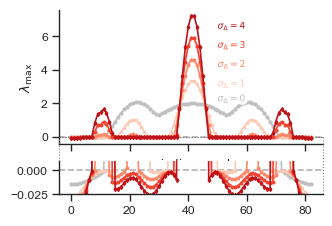

In [23]:
m = 5
N = 83
r = 2
r1 = 1
r2 = range(m)
Lambda_2 = np.zeros((N, m), dtype=np.complex_)

for q in range(N):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N, r1, r2[j], q, r)

fig, (ax, axins1) = plt.subplots(
    2, 1, figsize=(3.4, 2.4), height_ratios=[4, 1], sharex=True
)

ax.set_xlabel(r"$q$, winding number")
ax.set_ylabel(r"$\lambda_\mathrm{max}$")

markers = ["o", "s", "p", "h", "d"]
labels = [
    r"$\sigma_\Delta=0$",
    r"$\sigma_\Delta=1$",
    r"$\sigma_\Delta=2$",
    r"$\sigma_\Delta=3$",
    r"$\sigma_\Delta=4$",
]

colors = ["silver"] + sb.color_palette("Reds", n_colors=len(labels) - 1)

for i in range(m):
    ax.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker=markers[i],
        ms=2,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

ax.axhline(0, linestyle="--", alpha=0.6, c="grey", zorder=-2)


from labellines import labelLine, labelLines

legs = labelLines(
    ax.get_lines(),
    zorder=2.5,
    xvals=[40] * 5,
    yoffsets=[0.3] + [0.05] * 5,
    fontsize="x-small",
    align=False,
)
x_offset = 15
for leg in legs:
    x, y = leg.get_position()
    leg.set_position((x + x_offset, y))


for i in range(m):
    axins1.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker=markers[i],
        ms=2,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

axins1.set_ylim(ymax=0.01, ymin=-0.025)
# axins1.set_xlim([-2, 40])
axins1.axhline(0, linestyle="--", alpha=0.6, c="grey", zorder=-2)

axins1.set_ylabel("")
# plt.yticks(fontsize="x-small")
# axins1.set_xticks([])
# plt.xticks(fontsize="x-small")
# plt.xlabel(fontsize="x-small", labelpad=3)
# axins1.tick_params('both', length=2, which='major', pad=1)

mark_inset(ax, axins1, loc1=2, loc2=4, ec="0.5", ls=":")

sb.despine()

# plt.savefig("lambda2.pdf")

## Fraction of stable states

In [24]:
m = 50
N1 = 83
N2 = 830
r = 2
k1 = 1
k2 = np.linspace(0, 10, num=m)

Lambda_2 = np.zeros((N1, m), dtype=np.complex_)
for q in range(N1):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N1, k1, k2[j], q, r)
stable_fraction1 = np.mean(Lambda_2 < 0, axis=0)

Lambda_2 = np.zeros((N2, m), dtype=np.complex_)
for q in range(N2):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N2, k1, k2[j], q, r)
stable_fraction2 = np.mean(Lambda_2 < 0, axis=0)

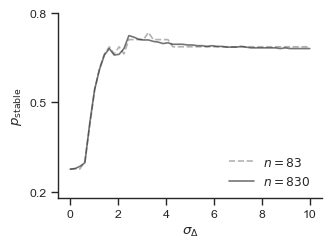

In [25]:
fig, ax = plt.subplots(figsize=(3.4, 2.4))

ax.set_xlabel(r"$\sigma_\Delta$")
ax.set_ylabel(r"$p_\mathrm{stable}$")


ax.plot(
    k2,
    stable_fraction1,
    linestyle="--",
    color="grey",
    alpha=0.6,
    label=r"$n=83$",
)
ax.plot(
    k2,
    stable_fraction2,
    linestyle="-",
    color="k",
    alpha=0.6,
    label=r"$n=830$",
)

# ax.set_xticks([0, 2, 4])
ax.set_yticks([0.2, 0.5, 0.8])
ax.set_ylim(ymin=0.18)


ax.legend(loc="lower right", frameon=False, ncol=1)

sb.despine()


# plt.savefig("stable_fraction.pdf")

## All together

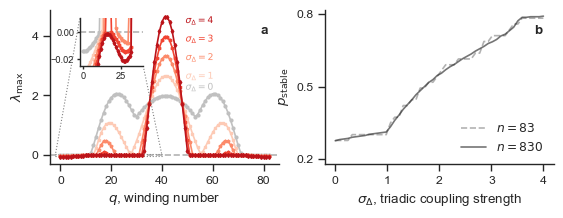

In [6]:
m = 5
N = 83
r = 2
r1 = 1
r2 = range(m)
Lambda_2 = np.zeros((N, m), dtype=np.complex_)

for q in range(N):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N, r1, r2[j], q, r)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(6.5, 2))

ax.set_xlabel(r"$q$, winding number")
ax.set_ylabel(r"$\lambda_\mathrm{max}$")

markers = ["o", "s", "p", "h", "d"]
labels = [
    r"$\sigma_\Delta=0$",
    r"$\sigma_\Delta=1$",
    r"$\sigma_\Delta=2$",
    r"$\sigma_\Delta=3$",
    r"$\sigma_\Delta=4$",
]

colors = ["silver"] + sb.color_palette("Reds", n_colors=len(labels) - 1)

for i in range(m):
    ax.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker=markers[i],
        ms=2,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

ax.axhline(0, linestyle="--", alpha=0.6, c="grey", zorder=-2)
ax.set_yticks([0, 2, 4])

from labellines import labelLine, labelLines

legs = labelLines(
    ax.get_lines(),
    zorder=2.5,
    xvals=[40] * 5,
    yoffsets=[0.3] + [0.05] * 5,
    fontsize="x-small",
    align=False,
)
x_offset = 15
for leg in legs:
    x, y = leg.get_position()
    leg.set_position((x + x_offset, y))


# insets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

axins1 = inset_axes(
    ax,
    width="100%",
    height="100%",
    bbox_to_anchor=(10, 3.2, 25, 1.6),
    bbox_transform=ax.transData,
)

for i in range(m):
    axins1.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker=markers[i],
        ms=2,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

axins1.set_ylim([-0.025, 0.01])
axins1.set_xlim([-2, 40])
axins1.axhline(0, linestyle="--", alpha=0.6, c="grey", zorder=-2)

axins1.set_ylabel("")
plt.yticks([0, -0.02], fontsize="x-small")
# axins1.set_xticks([])
plt.xticks(fontsize="x-small")
# plt.xlabel(fontsize="x-small", labelpad=3)
axins1.tick_params("both", length=2, which="major", pad=2)

mark_inset(ax, axins1, loc1=2, loc2=4, ec="0.5", ls=":")


sb.despine()

#######
# other one
##########

m = 50
N1 = 83
N2 = 830
r = 2
r1 = 1
r2 = np.linspace(0, 4, num=m)

Lambda_2 = np.zeros((N1, m), dtype=np.complex_)
for q in range(N1):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N1, r1, r2[j], q, r)
stable_fraction1 = np.mean(Lambda_2 < 0, axis=0)

Lambda_2 = np.zeros((N2, m), dtype=np.complex_)
for q in range(N2):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N2, r1, r2[j], q, r)
stable_fraction2 = np.mean(Lambda_2 < 0, axis=0)


ax2.set_xlabel(r"$\sigma_\Delta$, triadic coupling strength")
ax2.set_ylabel(r"$p_\mathrm{stable}$")


ax2.plot(
    r2,
    stable_fraction1,
    linestyle="--",
    color="grey",
    alpha=0.6,
    label=r"$n=83$",
)
ax2.plot(
    r2,
    stable_fraction2,
    linestyle="-",
    color="k",
    alpha=0.6,
    label=r"$n=830$",
)

# ax.set_xticks([0, 2, 4])
ax2.set_yticks([0.2, 0.5, 0.8])
ax2.set_ylim(ymin=0.18)


ax2.legend(loc="lower right", frameon=False, ncol=1)

ax.text(0.95, 0.9, "a", transform=ax.transAxes, weight="bold", va="top", ha="right")
ax2.text(0.95, 0.9, "b", transform=ax2.transAxes, weight="bold", va="top", ha="right")

sb.despine()


plt.savefig("../results/figure_1.pdf", dpi=250, bbox_inches="tight", pad_inches=0)

Text(1.2, 0.7, 'c')

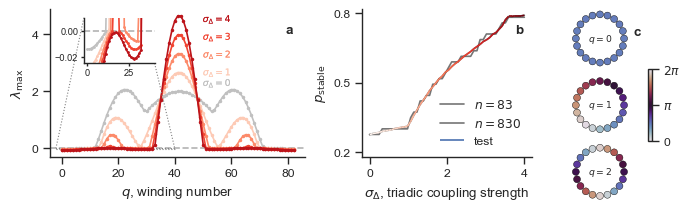

In [55]:
m = 5
N = 83
r = 2
r1 = 1
r2 = range(m)
Lambda_2 = np.zeros((N, m), dtype=np.complex_)

for q in range(N):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N, r1, r2[j], q, r)

fig = plt.figure(figsize=(6.8, 2), layout="constrained")

subfigs = fig.subfigures(1, 2, wspace=0.05, width_ratios=[4, 1])

(ax, ax2) = subfigs[0].subplots(1, 2, width_ratios=[1.5, 1])

axs1 = subfigs[1].subplots(3, 1)


ax.set_xlabel(r"$q$, winding number")
ax.set_ylabel(r"$\lambda_\mathrm{max}$")

markers = ["o", "s", "p", "h", "d"]
labels = [
    r"$\sigma_\Delta=0$",
    r"$\sigma_\Delta=1$",
    r"$\sigma_\Delta=2$",
    r"$\sigma_\Delta=3$",
    r"$\sigma_\Delta=4$",
]

colors = ["silver"] + sb.color_palette("Reds", n_colors=len(labels) - 1)

for i in range(m):
    ax.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker="o",  # markers[i],
        ms=1.5,
        # mfc="w",
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

ax.axhline(0, linestyle="--", alpha=0.6, c="grey", zorder=-2)
ax.set_yticks([0, 2, 4])

from labellines import labelLine, labelLines

legs = labelLines(
    ax.get_lines(),
    zorder=2.5,
    xvals=[40] * 5,
    yoffsets=[0.3] + [0.05] * 5,
    fontsize="x-small",
    align=False,
    outline_width=0,
)
x_offset = 15
for leg in legs:
    x, y = leg.get_position()
    leg.set_position((x + x_offset, y))


# insets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

axins1 = inset_axes(
    ax,
    width="100%",
    height="100%",
    bbox_to_anchor=(10, 3.2, 25, 1.6),
    bbox_transform=ax.transData,
)

for i in range(m):
    axins1.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker="o",  # markers[i],
        ms=1,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

axins1.set_ylim([-0.025, 0.01])
axins1.set_xlim([-2, 40])
axins1.axhline(0, linestyle="--", alpha=0.6, c="grey", zorder=-2)

axins1.set_ylabel("")
plt.yticks([0, -0.02], fontsize="x-small")
# axins1.set_xticks([])
plt.xticks(fontsize="x-small")
# plt.xlabel(fontsize="x-small", labelpad=3)
axins1.tick_params("both", length=2, which="major", pad=2)

mark_inset(ax, axins1, loc1=2, loc2=4, ec="0.5", ls=":")


sb.despine()

#######
# other one
##########

m = 50
N1 = 83
N2 = 830
r = 2
r1 = 1
r2 = np.linspace(0, 4, num=m)

Lambda_2 = np.zeros((N1, m), dtype=np.complex_)
for q in range(N1):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N1, r1, r2[j], q, r)
stable_fraction1 = np.mean(Lambda_2 < 0, axis=0)

Lambda_2 = np.zeros((N2, m), dtype=np.complex_)
for q in range(N2):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N2, r1, r2[j], q, r)
stable_fraction2 = np.mean(Lambda_2 < 0, axis=0)


ax2.set_xlabel(r"$\sigma_\Delta$, triadic coupling strength")
ax2.set_ylabel(r"$p_\mathrm{stable}$")


ax2.plot(
    r2,
    stable_fraction1,
    linestyle="-",
    color="k",
    alpha=0.6,
    label=r"$n=83$",
)
ax2.plot(
    r2,
    stable_fraction2,
    linestyle="-",
    color="k",
    alpha=0.6,
    label=r"$n=830$",
)

# Create a colormap
cmap = plt.get_cmap("Reds")  # You can choose any colormap you like
x = r2
y = stable_fraction2
# Create segments for the colored line
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection with varying colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap=cmap, norm=norm, label="test")
lc.set_array(x)  # Assign colors based on the x values
ax2.add_collection(lc)


# ax.set_xticks([0, 2, 4])
ax2.set_yticks([0.2, 0.5, 0.8])
ax2.set_ylim(ymin=0.18)


ax2.legend(loc="lower right", frameon=False, ncol=1)

ax.text(0.95, 0.9, "a", transform=ax.transAxes, weight="bold", va="top", ha="right")
ax2.text(0.95, 0.9, "b", transform=ax2.transAxes, weight="bold", va="top", ha="right")

sb.despine()

## rings
########

N = 20

for q in range(3):
    # cbar=True if q==2 else False
    psi = generate_q_twisted_state(N, q)
    H = xgi.trivial_hypergraph(N)
    _, im = plot_phases_ring(
        H, psi[:, None], ax=axs1[q], colorbar=False, node_size=5, node_lw=0.3
    )

    axs1[q].text(0, 0, f"$q={q}$", fontsize="x-small", va="center", ha="center")

cbar = fig.colorbar(im, ax=axs1, shrink=0.6, fraction=0.05, pad=0.1)
cbar.set_ticks(ticks=[0, np.pi, 2 * np.pi], labels=[0, r"$\pi$", r"$2\pi$"])

axs1[0].text(
    1.2, 0.7, "c", transform=axs1[0].transAxes, weight="bold", va="top", ha="right"
)


# plt.savefig("../results/figure_1_v2.pdf", dpi=250, bbox_inches="tight", pad_inches=0)

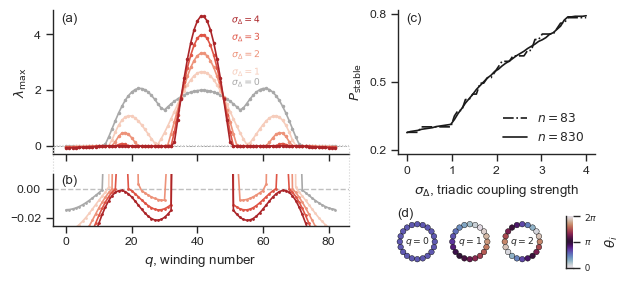

In [38]:
m = 5
N = 83
r = 2
r1 = 1
r2 = range(m)
Lambda_2 = np.zeros((N, m), dtype=np.complex_)

for q in range(N):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N, r1, r2[j], q, r)

fig, ([[ax, ax2], [axins1, ax1]]) = plt.subplots(
    2, 2, figsize=(7, 2.8), height_ratios=[2.8, 1], width_ratios=[1.5, 1], sharex=False
)

axins1.set_xlabel(r"$q$, winding number")
ax.set_ylabel(r"$\lambda_\mathrm{max}$")

markers = ["o", "s", "p", "h", "d"]
labels = [
    r"$\sigma_\Delta=0$",
    r"$\sigma_\Delta=1$",
    r"$\sigma_\Delta=2$",
    r"$\sigma_\Delta=3$",
    r"$\sigma_\Delta=4$",
]

colors = ["darkgrey"] + sb.color_palette("Reds", n_colors=len(labels) - 1, desat=0.8)

for i in range(m):
    ax.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker="o",  # "markers"[i],
        ms=1.5,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

ax.axhline(0, linestyle="--", alpha=0.6, c="k", zorder=-2, lw=0.5)


from labellines import labelLine, labelLines

legs = labelLines(
    ax.get_lines(),
    zorder=2.5,
    xvals=[40] * 5,
    yoffsets=[0.3] + [0.05] * 5,
    fontsize="x-small",
    align=False,
)
x_offset = 15
for leg in legs:
    x, y = leg.get_position()
    leg.set_position((x + x_offset, y))


for i in range(m):
    axins1.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker="o",  # "markers"[i],
        ms=1,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

axins1.set_ylim(ymax=0.01, ymin=-0.025)
# axins1.set_xlim([-2, 40])
axins1.axhline(0, linestyle="--", alpha=1, c="silver", zorder=-1, lw=1)

axins1.set_ylabel("")
# plt.yticks(fontsize="x-small")
# axins1.set_xticks([])
# plt.xticks(fontsize="x-small")
# plt.xlabel(fontsize="x-small", labelpad=3)
# axins1.tick_params('both', length=2, which='major', pad=1)

mark_inset(ax, axins1, loc1=2, loc2=4, ec="lightgrey", ls=":")


#######
# other one
##########

m = 50
N1 = 83
N2 = 830
r = 2
r1 = 1
r2 = np.linspace(0, 4, num=m)

Lambda_2 = np.zeros((N1, m), dtype=np.complex_)
for q in range(N1):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N1, r1, r2[j], q, r)
stable_fraction1 = np.mean(Lambda_2 < 0, axis=0)

Lambda_2 = np.zeros((N2, m), dtype=np.complex_)
for q in range(N2):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N2, r1, r2[j], q, r)
stable_fraction2 = np.mean(Lambda_2 < 0, axis=0)


ax2.set_xlabel(r"$\sigma_\Delta$, triadic coupling strength")
ax2.set_ylabel(r"$P_\mathrm{stable}$")


ax2.plot(
    r2,
    stable_fraction1,
    linestyle="-.",
    color="k",
    # alpha=0.6,
    label=r"$n=83$",
)
ax2.plot(
    r2,
    stable_fraction2,
    linestyle="-",
    color="k",
    # alpha=0.6,
    label=r"$n=830$",
)

# ax.set_xticks([0, 2, 4])
ax2.set_yticks([0.2, 0.5, 0.8])
ax2.set_ylim(ymin=0.18)
axins1.set_yticks([0, -0.02])

ax.set_xticklabels([])

ax2.legend(loc="lower right", frameon=False, ncol=1)


## rings

N = 20

for q in range(3):
    # cbar=True if q==2 else False
    psi = generate_q_twisted_state(N, q)
    H = xgi.trivial_hypergraph(N)

    pos = xgi.circular_layout(H, center=[1 + 4.5 * q, 0], radius=1.5)
    psi = psi % (2 * np.pi)
    _, im = xgi.draw_nodes(
        H,
        pos=pos,
        ax=ax1,
        node_fc=psi,
        vmin=0,
        vmax=2 * np.pi,
        node_fc_cmap="twilight",
        node_size=4,
        node_lw=0.3,
    )

    ax1.text(1 + 4.5 * q, 0, f"$q={q}$", fontsize="x-small", va="center", ha="center")

    # _, im = plot_phases_ring(H, psi[:, None], ax=ax, colorbar=False, node_size=5)


ax1.set_aspect("equal")

cbar = plt.colorbar(im, aspect=7, label=r"$\theta_i$")
cbar.set_ticks(
    ticks=[0, np.pi, 2 * np.pi], labels=[0, r"$\pi$", r"$2\pi$"], fontsize="x-small"
)
cbar.outline.set_visible(False)

pos1 = ax1.get_position()  # get the original position
pos2 = [pos1.x0 - 0.01, pos1.y0 - 0.15, pos1.width, pos1.height]
ax1.set_position(pos2)  # set a new position

cax = cbar.ax
pos1 = cax.get_position()  # get the original position
pos2 = [pos1.x0, pos1.y0 - 0.15, pos1.width, pos1.height]
cax.set_position(pos2)  # set a new position
# cbar.outline.set_linewidth(0.1)

ax.text(0.03, 0.98, "(a)", transform=ax.transAxes, weight="normal", va="top", ha="left")
axins1.text(
    0.03, 0.98, "(b)", transform=axins1.transAxes, weight="normal", va="top", ha="left"
)

ax2.text(
    0.04, 0.98, "(c)", transform=ax2.transAxes, weight="normal", va="top", ha="left"
)
ax1.text(
    0.04, 1.3, "(d)", transform=ax1.transAxes, weight="normal", va="top", ha="left"
)


sb.despine()

plt.savefig("../results/figure_1_v3.pdf", dpi=250, bbox_inches="tight", pad_inches=0)